<a href="https://colab.research.google.com/github/BradenEberhard/FakeNews/blob/main/FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langdetect
# Install transformers library.
!pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions.
!pip install -q git+https://github.com/gmihaila/ml_things.git
import pandas as pd
import io
import os
import torch
import pdb
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

     |████████████████████████████████| 983kB 8.6MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.8-cp37-none-any.whl size=993193 sha256=5759d1512d93a25c85108fc8a9651004817d87085dada951f71e220d309b663a
  Stored in directory: /root/.cache/pip/wheels/8d/b3/aa/6d99de9f3841d7d3d40a60ea06e6d669e8e5012e6c8b947a57
Successfully built langdetect
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 890kB 7.6MB/s 
     |████████████████████████████████| 3.2MB 40.9MB/s 
     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 10.3MB 12.6MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


/usr/local/lib/python3.7/dist-packages/packaging/version.py:130: DeprecationWarning: Creating a LegacyVersion has been deprecated and will be removed in the next major release
  DeprecationWarning,


In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train = pd.read_csv('./drive/MyDrive/Models/Fake News/train.csv')
test = pd.read_csv('./drive/MyDrive/Models/Fake News/test.csv')
cleaned_data = pd.read_csv('./drive/MyDrive/Models/Fake News/CleanFakeNews.csv')
train.Set = 'train'
test.Set = 'test'
data = pd.concat([train, test])
data.index = data.id
merged_data = pd.concat([data, cleaned_data.loc[:,('Id','language.x','Set') ]], axis = 1)
merged_data_eng = merged_data[merged_data['language.x'] == 'english']

# Dataset


In [ ]:
class TextDataset(Dataset):
  """PyTorch Dataset class for loading data.
  This is where the data parsing happens.
  This class is built with reusability in mind: it can be used as is as.
  Arguments:
    path (:obj:`str`):
        Path to the data partition.
  """
  def __init__(self, df, use_tokenizer):
    self.texts = df.text.to_numpy()
    self.labels = df.label.to_numpy()
    return
  def __len__(self):
    """When used `len` return the number of examples."""   
    return len(self.labels)
  def __getitem__(self, item):
    """Given an index return an example from the position.   
    Arguments:
      item (:obj:`int`):
          Index position to pick an example to return.
    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.
    """
    return {'text':self.texts[item],
            'label':self.labels[item]}

# Collator

In [ ]:

class Gpt2ClassificationCollator(object):
    """
    Data Collator used for GPT2 in a classificaiton rask. 
    
    It uses a given tokenizer and label encoder to convert any text and labels to numbers that 
    can go straight into a GPT2 model.

    This class is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.

    Arguments:

      use_tokenizer (:obj:`transformers.tokenization_?`):
          Transformer type tokenizer used to process raw text into numbers.

      labels_ids (:obj:`dict`):
          Dictionary to encode any labels names into numbers. Keys map to 
          labels names and Values map to number associated to those labels.

      max_sequence_len (:obj:`int`, `optional`)
          Value to indicate the maximum desired sequence to truncate or pad text
          sequences. If no value is passed it will used maximum sequence size
          supported by the tokenizer and model.

    """

    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):

        # Tokenizer to be used inside the class.
        self.use_tokenizer = use_tokenizer
        # Check max sequence length.
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class.
        self.labels_encoder = labels_encoder

        return

    def __call__(self, sequences):
        """
        This function allowes the class objesct to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this 
        class as a function.

        Arguments:

          item (:obj:`list`):
              List of texts and labels.

        Returns:
          :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
          It holddes the statement `model(**Returned Dictionary)`.
        """

        # Get all texts from sequences list.
        texts = [sequence['text'] for sequence in sequences]
        labels = [sequence['label'] for sequence in sequences]
        # Call tokenizer on all texts to convert into tensors of numbers with 
        # appropriate padding.
        try:
          inputs = self.use_tokenizer(text=texts, return_tensors="pt", padding=True, truncation=True,  max_length=self.max_sequence_len)
        except:
          pdb.set_trace()
          print(texts)
          print(len(texts))
          pass
        # Update the inputs with the associated encoded labels as tensor.
        inputs.update({'labels':torch.tensor(labels)})
        

        return inputs

# Training loop

In [ ]:
def train(dataloader, optimizer_, scheduler_, device_):
  """
  Train pytorch model on a single pass through the data loader.
  It will use the global variable `model` which is the transformer model 
  loaded on `_device` that we want to train on.
  This function is built with reusability in mind: it can be used as is as long
    as the `dataloader` outputs a batch in dictionary format that can be passed 
    straight into the model - `model(**batch)`.
  Arguments:
      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.
      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.
      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
  Returns:
      :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted
        Labels, Train Average Loss].
  """
  # Use global variable for model.
  global model
  # Tracking variables.
  predictions_labels = []
  true_labels = []
  # Total loss for this epoch.
  total_loss = 0

  # Put the model into training mode.
  model.train()

  # For each batch of training data...
  for batch in tqdm(dataloader, total=len(dataloader)):

    # Add original labels - use later for evaluation.
    true_labels += batch['labels'].numpy().flatten().tolist()
    
    # move batch to device
    batch = {k:v.type(torch.long).to(device_) for k,v in batch.items()}
    
    # Always clear any previously calculated gradients before performing a
    # backward pass.
    model.zero_grad()

    # Perform a forward pass (evaluate the model on this training batch).
    # This will return the loss (rather than the model output) because we
    # have provided the `labels`.
    # The documentation for this a bert model function is here: 
    # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
    outputs = model(**batch)

    # The call to `model` always returns a tuple, so we need to pull the 
    # loss value out of the tuple along with the logits. We will use logits
    # later to calculate training accuracy.
    loss, logits = outputs[:2]

    # Accumulate the training loss over all of the batches so that we can
    # calculate the average loss at the end. `loss` is a Tensor containing a
    # single value; the `.item()` function just returns the Python value 
    # from the tensor.
    total_loss += loss.item()

    # Perform a backward pass to calculate the gradients.
    loss.backward()

    # Clip the norm of the gradients to 1.0.
    # This is to help prevent the "exploding gradients" problem.
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Update parameters and take a step using the computed gradient.
    # The optimizer dictates the "update rule"--how the parameters are
    # modified based on their gradients, the learning rate, etc.
    optimizer.step()

    # Update the learning rate.
    scheduler.step()

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()

    # Convert these logits to list of predicted labels values.
    predictions_labels += logits.argmax(axis=-1).flatten().tolist()

  # Calculate the average loss over the training data.
  avg_epoch_loss = total_loss / len(dataloader)
  
  # Return all true labels and prediction for future evaluations.
  return true_labels, predictions_labels, avg_epoch_loss

# Configure

In [ ]:
set_seed(123)
epochs = 4
# Number of batches - depending on the max sequence length and GPU memory.
# For 512 sequence length batch of 10 works without cuda memory issues.
# For small sequence length can try batch of 32 or higher.
batch_size = 32
# Pad or truncate text sequences to a specific length
# if `None` it will use maximum sequence of word piece tokens allowed by model.
max_length = 60
# Name of transformers model - will use already pretrained model.
# Path of transformer model - will load your own model from local disk.
model_name_or_path = 'gpt2'
# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'neg': 0, 'pos': 1}
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = 2
# Get model configuration.
print('Loading configuraiton...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path=model_name_or_path)
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model = model.cuda()
print('Model loaded')

Loading configuraiton...



Loading tokenizer...



Loading model...


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded


# Run Loop

In [ ]:
gpt2_classificaiton_collator = Gpt2ClassificationCollator(use_tokenizer=tokenizer, 
                                                          labels_encoder=labels_ids, 
                                                          max_sequence_len=max_length)

train_dataset = TextDataset(df=merged_data_eng[merged_data_eng.Set == 'train'], use_tokenizer=tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classificaiton_collator)

optimizer = AdamW(model.parameters(), lr = 2e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

all_loss = []
all_acc = []
for epoch in tqdm(range(epochs)):
  train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
  train_acc = accuracy_score(train_labels, train_predict)
  all_loss.append(train_loss)
  all_acc.append(train_acc)

In [ ]:
torch.save({
    'model_state_dict': model.state_dict()
}, './drive/MyDrive/Models/Fake_News_GPT2')

In [ ]:
test_set = merged_data_eng[merged_data_eng['Set']=='test']
test_set.label = 1
test_dataset = TextDataset(df=test_set, use_tokenizer=tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=gpt2_classificaiton_collator)

predictions_labels = []
true_labels = []
total_loss = 0
model.eval()
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
  true_labels += batch['labels'].numpy().flatten().tolist()
  batch = {k:v.type(torch.long).to(device) for k,v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
    loss, logits = outputs[:2]
    logits = logits.detach().cpu().numpy()
    total_loss += loss.item()
    predict_content = logits.argmax(axis=-1).flatten().tolist()
    predictions_labels += predict_content



/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
test_set.label = predictions_labels
full_test = merged_data[merged_data['Set'] == 'test']
out = pd.concat([test_set, full_test['id']], axis=1, join='outer')
labels = out['label']
labels[out['label'].isna()] = 1
out.label = 1 - labels

submission = pd.DataFrame({'id':out.index, 'label':out.label})
submission.to_csv('./submit.csv', index = False)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


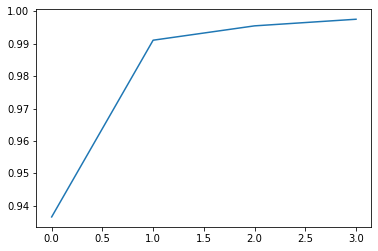

In [ ]:
plt.plot(all_acc)

since GPT2 tokenizers stick mainly to english i stole my professors predictions for the non english values below. I think he used some sort of XGBoosted forest with id_tf values in the cleaned_data 

In [48]:
my_submission = pd.read_csv('./drive/MyDrive/Models/Fake News/submit-3.csv')
heatons_submit = pd.read_csv('./drive/MyDrive/Models/Fake News/fakeNewsPreds.csv')
non_eng_test = cleaned_data.loc[(cleaned_data['language.x'] != 'english') & (cleaned_data['Set'] == 'test')]
merge_frame = heatons_submit[heatons_submit['id'].isin(non_eng_test['Id'])]
output = pd.concat([my_submission[~my_submission['id'].isin(non_eng_test['Id'])], merge_frame])
output.to_csv('./submit.csv', index = False)